# This code demonstrates a Hidden markov modeling of conformational transitions from AFM images

# load required packages

In [1]:
using Statistics, Plots, DelimitedFiles
using Revise; using MDToolbox

┌ Warning: no Manifest.toml file found, static paths used
└ @ Revise /Users/yasu/.julia/packages/Revise/BqeJF/src/Revise.jl:1328
┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1260


In [2]:
using BSON: @save, @load
@load "data/t1r/t1r.bson" C T pi_i p_all indexOfCluster tau pdb psf

In [3]:
nstate = size(T, 1)

50

# generate AFM data

In [4]:
nframe = 1000
state = msmgenerate(nframe, T, pi_i);

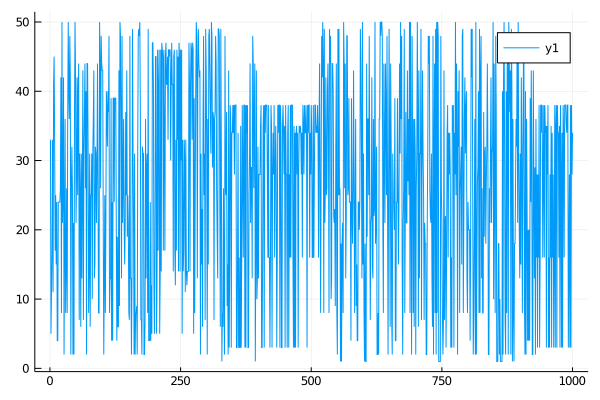

In [7]:
plot(state)

# calculate emissions

In [90]:
# quaternion
qs = readdlm("data/quaternion/QUATERNION_LIST_576_Orient");

In [91]:
# model
models = pdb
for iatom = 1:models.natom
    models.atomname[iatom] = models.resname[iatom]
end
decenter!(models)
models = superimpose(models[1, :], models);

In [92]:
# afm
probe_radius = 20.0
afmize_config = AfmizeConfig(10.0 * (pi / 180),
    probe_radius, 
    MDToolbox.Point2D(-250, -200), 
    MDToolbox.Point2D(250, 200), 
    MDToolbox.Point2D(6.25, 6.25), 
    MDToolbox.defaultParameters())

sigma_noise = 3.0

afms = []
for iframe in 1:nframe
    model = models[state[iframe], :]
    afm = afmize(model, afmize_config)
    h, w = size(afm)
    afm .+= randn(h, w) * sigma_noise
    push!(afms, afm)
end
@save "msm_hmm_afm.bson" afms models state qs afmize_config probe_radius sigma_noise

In [93]:
#anim = @animate for i = 1:length(afms)
#    heatmap(afms[i])
#end
#gif(anim, "msm_hmm_afm.gif", fps = 10)

In [94]:
configs = [AfmizeConfig(10.0 * (pi / 180),
    r, 
    MDToolbox.Point2D(-250, -200), 
    MDToolbox.Point2D(250, 200), 
    MDToolbox.Point2D(6.25, 6.25), 
    MDToolbox.defaultParameters())
    for r in [10.0, 15.0, 20.0, 25.0, 30.0]]

5-element Array{AfmizeConfig,1}:
 AfmizeConfig(0.17453292519943295, 10.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 15.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 20.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point2D{Int64}(250, 200), MDToolbox.Point2D{Float64}(6.25, 6.25), Dict("SI" => 2.1,"GLN" => 3.0,"GLU" => 2.95,"C" => 1.7,"MG" => 1.73,"P" => 1.8,"LYS" => 3.2,"GLY" => 2.25,"ASN" => 2.85,"NE" => 1.54…))
 AfmizeConfig(0.17453292519943295, 25.0, MDToolbox.Point2D{Int64}(-250, -200), MDToolbox.Point

In [24]:
res = []
for i = 1:nframe
    @show i
    res2 = getafmposterior(afms[i], models, qs, configs)
    push!(res, res2)
end

i = 1
size(model_array, 1) = 5
imodel = 3
imodel = 4
imodel = 5
imodel = 1
imodel = 2
i = 2
size(model_array, 1) = 5
imodel = 3
imodel = 4
imodel = 5
imodel = 1
imodel = 2


In [6]:
@load "msm_hmm_afm.bson" afms models state qs afmize_config probe_radius sigma_noise
@load "msm_hmm_afm.posterior.bson" res

In [8]:
res[1][end]

50-element Array{Float64,1}:
 3.153061278677328e-117
 5.7827677919150816e-108
 5.321061182149278e-201
 2.222815314466328e-101
 5.504633502934358e-153
 2.3039992897394784e-124
 3.466323281698517e-139
 1.4631649817405413e-72
 0.0021269411095406125
 4.614752869047667e-6
 7.089595214821103e-100
 4.153639050768465e-146
 4.028418112379875e-54
 ⋮
 1.8030458702551063e-80
 2.131469532781955e-99
 4.807555483175757e-127
 1.0331255934110817e-23
 2.6556984381454485e-125
 3.615652469147314e-81
 2.3966752200639107e-131
 5.598823842448148e-151
 4.073714749348099e-148
 4.342263417044597e-22
 1.3861426743631345e-124
 1.0387038423078085e-93

In [9]:
emission = zeros(Float64, nstate, nframe)
for i = 1:nframe
    emission[:, i] .= res[i][end]
end

emission .= emission .+ 0.0001
emission .= emission ./ sum(emission, dims=2)

50×1000 Array{Float64,2}:
 0.000911434  0.000911434  0.000911434  …  0.000911434  0.000911434
 2.56857e-6   2.56857e-6   2.56857e-6      2.56857e-6   2.56857e-6
 0.001        0.001        0.001           0.001        0.001
 2.04699e-6   2.04699e-6   2.04699e-6      2.04699e-6   2.04699e-6
 7.24389e-7   7.24389e-7   7.24389e-7      7.24389e-7   0.00724461
 5.25039e-6   5.25039e-6   5.25039e-6   …  5.25039e-6   5.25039e-6
 0.001        0.001        0.001           0.001        0.001
 9.09091e-5   9.09091e-5   9.09091e-5      9.09091e-5   9.09091e-5
 0.00105934   4.75694e-5   4.75694e-5      4.75694e-5   4.75694e-5
 3.21562e-5   0.307408     3.07377e-5      3.07377e-5   3.07377e-5
 9.08591e-5   9.08591e-5   9.08591e-5   …  9.08591e-5   9.08591e-5
 8.26446e-6   8.26446e-6   8.26446e-6      8.26446e-6   8.26446e-6
 4.28283e-5   4.28283e-5   4.28283e-5      4.28283e-5   4.28283e-5
 ⋮                                      ⋱               
 0.000996832  0.000996832  0.000996832     0.000996832 

In [10]:
observation = collect(1:nframe)

1000-element Array{Int64,1}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
  989
  990
  991
  992
  993
  994
  995
  996
  997
  998
  999
 1000

# Hidden markov modeling

In [11]:
# initial transition probabilities
T0 = rand(Float64, nstate, nstate)
T0 .= T0 ./ sum(T0, dims=2)
pi_i = T0[1, :]

50-element Array{Float64,1}:
 0.004921792081645271
 0.0025484228569988966
 0.009865610770058878
 0.02584129445674789
 0.03676520672384368
 0.002607132869868071
 0.010427071068268673
 0.0335359979860509
 0.03218495269688316
 0.007440779386865702
 0.013364865860899773
 0.007416958430404104
 0.025121356296219435
 ⋮
 0.012619169428767438
 0.025590672641720345
 0.03082539841342297
 0.0019418917073399016
 0.004302887707781497
 0.030852926709223634
 0.033615584513350935
 0.00968564084755058
 0.020946262443538016
 0.031738212466888654
 0.03179520192507564
 0.036278626866075

In [12]:
@time T1, pi_i1, emission1 = msmbaumwelch([observation], T0, pi_i, emission);

100 iteration LogLikelihood = -5.886009e+03  delta = 1.646371e-03  tolerance = 1.000000e-04
200 iteration LogLikelihood = -5.883412e+03  delta = 3.192952e-03  tolerance = 1.000000e-04
 16.667300 seconds (17.93 M allocations: 19.334 GiB, 13.13% gc time)


In [13]:
T1

50×50 Array{Float64,2}:
 1.17204e-119  1.484e-91     0.0           …  0.0           8.09495e-218
 0.0504605     0.0550632     0.0              0.0276603     0.0253698
 0.0           0.0           0.0921035        0.0           0.0
 9.72089e-71   0.08384       0.0              0.0           0.0
 2.52269e-256  0.0           6.97013e-281     0.0           0.0
 1.43892e-79   0.112946      0.0           …  0.056382      0.0565619
 3.84741e-192  1.09815e-156  0.0              1.18876e-220  2.41239e-279
 0.0           1.0           0.0              1.48479e-312  0.0
 0.0           0.0           0.0              0.0           0.0
 0.0           0.0           0.0              0.0           0.0
 0.0           1.0           0.0           …  0.0           0.0
 0.0           0.0           0.354703         0.0           0.0
 0.0           0.0           0.332091         0.0           0.0
 ⋮                                         ⋱                
 9.29551e-272  9.53483e-102  0.0              1.01502

# visualization

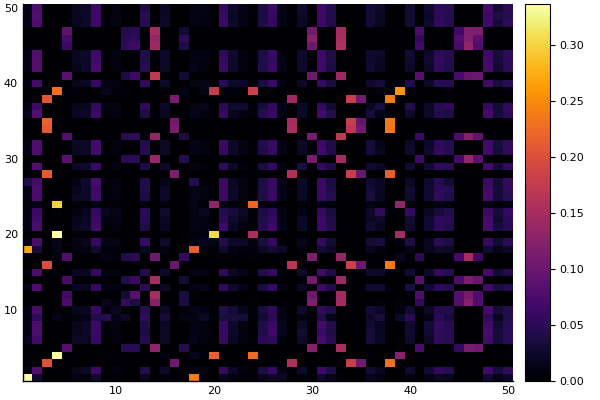

In [37]:
heatmap(T, zlim=(0,0.3))

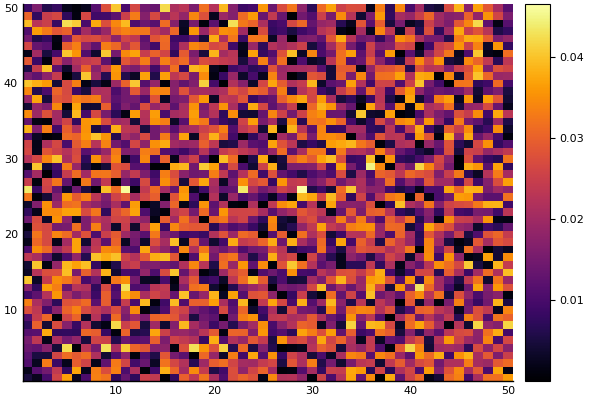

In [38]:
heatmap(T0, zlim=(0,0.3))

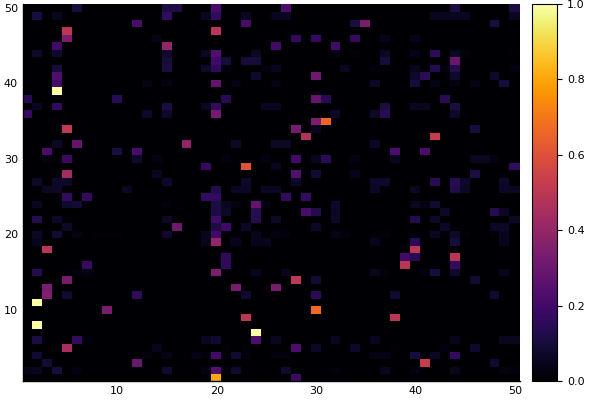

In [39]:
heatmap(T1, zlim=(0,0.3))

# Viterbi algorithm

In [17]:
@time state_estimated = msmviterbi(observation, T1, pi_i1, emission1);

  0.615716 seconds (2.40 M allocations: 120.002 MiB)


In [27]:
state_estimated2 = zeros(Int64, nframe);
for iframe = 1:nframe
    state_estimated2[iframe] = argmax(emission[:, iframe])
end

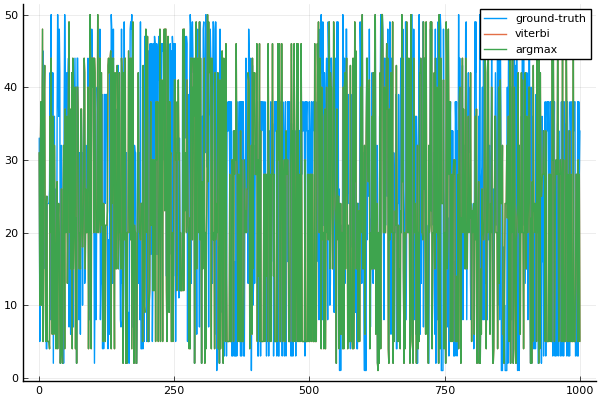

In [29]:
pyplot()
plot(state, line=(1), label="ground-truth")
plot!(state_estimated, line=(1), label="viterbi", legend=:topright)
plot!(state_estimated2, line=(1), label="argmax", legend=:topright)